In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from Evaluation import get_metrics
%load_ext autoreload
%autoreload 2

---
## Read Data

In [2]:
from Data_prep import leave_last_out

In [3]:
# path = 'C:/Users/robin.opdam/Google Drive/Thesis (Msc)/Thesis_shared_files/'
# path = '/Users/Robin/Google Drive/Thesis (Msc)/Thesis_shared_files/'
path = '../'

In [4]:
data_path = 'Data/Amazon/'
file_name = 'am_40k_users'

# data_path = 'Data/ML/'
# file_name = 'ml_1m'

In [5]:
df = pd.read_pickle(path + data_path + file_name)
total_items = df.item_id.nunique()
total_users = df.user_id.nunique()

In [6]:
# CFRNN Data
train_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_train_cfrnn')
val_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_val_cfrnn')
test_set_cfrnn = pd.read_pickle(path + data_path + file_name + '_test_cfrnn')

# MF based Data
train_set_mf = pd.read_pickle(path + data_path + file_name + '_train_mf')
val_set_mf = pd.read_pickle(path + data_path + file_name + '_val_mf')
test_set_mf = pd.read_pickle(path + data_path + file_name + '_test_mf')

## Create Datasets
- (to be moved to data_used)

In [11]:
train_set, test_set = cfrnn.data_split(df)
train_set, val_set = cfrnn.data_split(train_set, val=True)

In [10]:
from Data_prep import leave_last_out
add_to_train, val_set_mf = leave_last_out(val_set_cfrnn)
add_to_train_2, test_set_mf = leave_last_out(test_set_cfrnn)
train_set_mf = pd.concat([train_set_cfrnn, add_to_train, add_to_train_2])

In [ ]:
train_set_mf.to_pickle(path + data_path + file_name + '_train_mf')
val_set_mf.to_pickle(path + data_path + file_name + '_val_mf')
test_set_mf.to_pickle(path + data_path + file_name + '_test_mf')

In [13]:
# Eval
steps = 5
rank_at = 20

---
# BPR

In [47]:
bpr_params = {
"nolf": 8, #Size of latent feature vectors
"n_iterations": 20, #around 20 is sufficient
"sample_size": 0.5*len(train_set_mf),
"seed": 1234,
"alpha": 0.08, # Learning rate: Amazon_01 best: 0.08
"rho": 1.05, # Bold driver increase alpha
"sigma": 0.5, # Bold driver decrease alpha
          
"reg_user": 0.1, # Am_40k best: 0.1 # ML_1 best: 0
"reg_item": 0.1, # Am_40k best: 0.1 # ML_1 best: 0
}

In [61]:
from BPR import BPR
bpr = BPR(total_users, total_items, bpr_params)

In [62]:
samples_name = file_name + '_bpr_samples'

In [50]:
samples = bpr.create_samples(train_set_mf)

Creating 20 samples of length 174385


100% |########################################################################|


In [51]:
samples = np.array(samples)
np.save(path + data_path + 'Samples/' + samples_name, samples)

In [63]:
%%time
bpr.train_model(sample_path = path + data_path + 'Samples/' + samples_name + '.npy', val_set=val_set_mf)

Training BPR on 20 of size 174385
iteration: 0  loss: 0.708559  rec@10: 0.0
iteration: 1  loss: 0.705844  rec@10: 0.0
iteration: 2  loss: 0.703646  rec@10: 0.0
iteration: 3  loss: 0.701608  rec@10: 0.0
iteration: 4  loss: 0.699701  rec@10: 0.011
iteration: 5  loss: 0.697619  rec@10: 0.017
iteration: 6  loss: 0.695275  rec@10: 0.02
iteration: 7  loss: 0.692617  rec@10: 0.024
iteration: 8  loss: 0.689637  rec@10: 0.03
iteration: 9  loss: 0.686697  rec@10: 0.035
iteration: 10  loss: 0.683479  rec@10: 0.036
iteration: 11  loss: 0.680835  rec@10: 0.042
iteration: 12  loss: 0.677421  rec@10: 0.047
iteration: 13  loss: 0.674153  rec@10: 0.053
iteration: 14  loss: 0.671132  rec@10: 0.054
iteration: 15  loss: 0.667486  rec@10: 0.061
iteration: 16  loss: 0.664576  rec@10: 0.061
iteration: 17  loss: 0.660583  rec@10: 0.063
iteration: 18  loss: 0.657787  rec@10: 0.06
iteration: 19  loss: 0.654992  rec@10: 0.058
CPU times: user 4min 41s, sys: 6min 45s, total: 11min 26s
Wall time: 3min 23s


results added


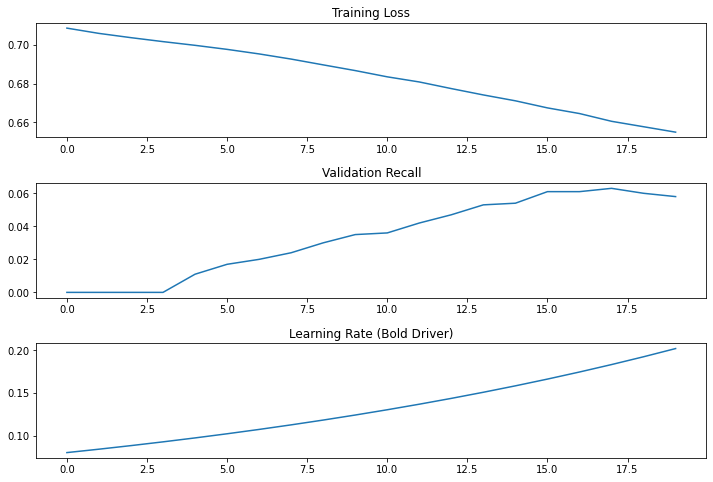

In [64]:
bpr.store_model(path + '/Logs/', file_name + '_bpr_log', file_name)
bpr.plot_training()

In [65]:
ranked_df_bpr = bpr.get_predictions(test_set_mf, stats=False)
bpr_metrics = get_metrics(ranked_df_bpr, steps, rank_at, stats=False)
bpr_metrics

,rank_at,hitcounts,recall,precision,ndcg
0,1,22,0.0110,0.011000,0.011000
1,5,102,0.0510,0.010200,0.031203
2,10,124,0.0620,0.006200,0.034708
3,15,132,0.0660,0.004400,0.035749
4,20,139,0.0695,0.003475,0.036567


In [66]:
bpr_metrics.to_pickle(path + 'Results/BPR/' + file_name + '_metrics')

---
# CFRNN

In [29]:
cfrnn_params = {
'train_time':0,
'epochs':100,
'BATCH_SIZE':32,
'learning_rate':0.1,
'delta':0.01,             # Diversity Bias
'max_seq_len':30,        # Max length of sequence71=median
'embedding_dim':100,
'rnn_units':20,
'ckpt_dir': path + f'Logs/ckpts/cfrnn_ckpts_{file_name}/ckpts',

'test_users': 500,
'val_users': 500,

'pad_value':total_items, # Pad with total_items+1 => masked => still use item 0
'shift_targets_by':1     
}

In [30]:
from CFRNN import CFRNN
cfrnn = CFRNN(total_users, total_items, cfrnn_params)
cfrnn.build_model(summary=False)
cfrnn.compile_model(train_set=train_set_cfrnn)

Creating Diveristy Bias
Compiled LSTM


In [31]:
train_dataset = cfrnn.create_seq_batch_tf_dataset(train_set_cfrnn, stats=False)
val_dataset = cfrnn.create_seq_batch_tf_dataset(val_set_cfrnn, stats=False)

In [32]:
cfrnn.train(train_dataset, val_dataset, verbose=1)

Fitting LSTM with parameters:
train_time                                              0
epochs                                                100
BATCH_SIZE                                             32
learning_rate                                         0.1
delta                                                0.01
max_seq_len                                            30
embedding_dim                                         100
rnn_units                                              20
ckpt_dir            ../Logs/ckpts/cfrnn_ckpts_ml_1m/ckpts
test_users                                            500
val_users                                             500
pad_value                                            3706
shift_targets_by                                        1
Name: 0, dtype: object
Train for 141 steps, validate for 15 steps
Epoch 1/100
141/141 [==============================] - 5s 36ms/step - loss: 7.7503 - recall: 0.0000e+00 - val_loss: 7.7563 - val_recall: 0.0000e+00
Ep

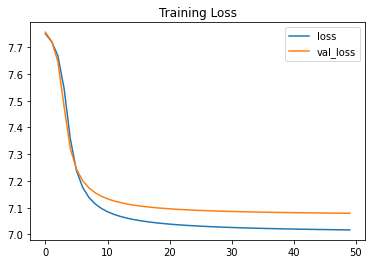

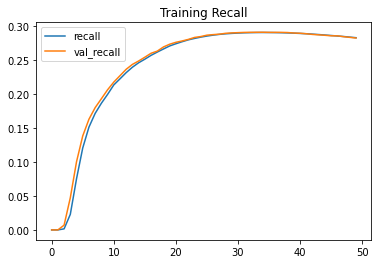

In [33]:
cfrnn.plot_training()

In [34]:
cfrnn_params['ckpt_dir']

'../Logs/ckpts/cfrnn_ckpts_ml_1m/ckpts'

In [35]:
test_set, left_out = leave_last_out(test_set_cfrnn, n_items=1)
ranked_df_cfrnn = cfrnn.get_predictions(train_set_cfrnn, test_set, left_out, batch_size=500, rank_at=rank_at, ckpt_dir=cfrnn_params['ckpt_dir'])
cfrnn_metrics = get_metrics(ranked_df_cfrnn, steps, rank_at, stats=False)
cfrnn_metrics

,rank_at,hitcounts,recall,precision,ndcg
0,1,4,0.004,0.004000,0.004000
1,5,19,0.019,0.003800,0.011119
2,10,43,0.043,0.004300,0.018755
3,15,71,0.071,0.004733,0.026086
4,20,92,0.092,0.004600,0.031059


In [36]:
cfrnn_metrics.to_pickle(path + 'Results/CFRNN/' + file_name + '_metrics')

---
# NCF

In [7]:
GMF_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'nolf': 8,
    'regs': [0.000001,0.000001],
    'epochs': 2,
    'sample_size': len(train_set_mf),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 4,
    'weights_dir': f'../Logs/weights/GMF_weights_{file_name}/GMF_weights',
    'optimizer':'Adam'
}

MLP_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'layers': [16,32,16,8],
    'reg_layers': [0.00001,0.00001,0.00001,0.00001],   #ML: [+-0.0005,0,0,0],
    'epochs': 2,
    'sample_size': len(train_set_mf),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 10,
    'weights_dir': f'../Logs/weights/MLP_weights_{file_name}/MLP_weights',
    'optimizer':'Adam'
}

NeuMF_params = {
    'learning_rate': 0.0005,
    'batch_size': 256,
    'layers': [16,32,16,8],
    'reg_layers': [0.00001,0.00001,0.00001,0.00001],#[0.0001, 0.0001, 0.0001, 0.0001],
    'reg_mf': [0.000001,0.000001],
    'nolf': 8,
    'epochs': 25,
    'sample_size': len(train_set_mf),#int(0.5*len(train_set.user_id.unique())),
    'num_neg': 4,
    'weights_dir': f'../Logs/weights/NeuMF_weights_{file_name}/NeuMF_weights',
    'optimizer':'Adam'
}

In [8]:
from NCF import NCF
NCF = NCF(total_users, total_items, GMF_params, MLP_params, NeuMF_params)
NCF.build_GMF_model()
NCF.build_MLP_model()
NCF.build_NeuMF_model()

In [9]:
sample_path = path + data_path + 'Samples/' + file_name + '_samples_4_neg/'
samples = NCF.load_samples(sample_path, file_name + '_sample', 25)

100% |########################################################################|


In [87]:
GMF_val_metrics = NCF.train_model('GMF', samples)


Fitting GMF with parameters:
learning_rate                                               0.0005
batch_size                                                     256
nolf                                                             8
regs                                                [1e-06, 1e-06]
epochs                                                           2
sample_size                                                 348771
num_neg                                                          4
weights_dir      ../Logs/weights/GMF_weights_am_40k_users/GMF_w...
optimizer                                                     Adam
Name: 0, dtype: object
Epoch: 0
Train on 1743855 samples


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1743855/1743855 [==============================] - 39s 22us/sample - loss: 0.5261
Epoch: 1
Train on 1743855 samples
1743855/1743855 [==============================] - 38s 22us/sample - loss: 0.4180


In [88]:
MLP_val_metrics = NCF.train_model('MLP', samples)


Fitting MLP with parameters:
learning_rate                                               0.0005
batch_size                                                     256
layers                                             [16, 32, 16, 8]
reg_layers                            [1e-05, 1e-05, 1e-05, 1e-05]
epochs                                                           2
sample_size                                                 348771
num_neg                                                         10
weights_dir      ../Logs/weights/MLP_weights_am_40k_users/MLP_w...
optimizer                                                     Adam
Name: 0, dtype: object
Epoch: 0
Train on 1743855 samples


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1743855/1743855 [==============================] - 42s 24us/sample - loss: 0.3821
Epoch: 1
Train on 1743855 samples
1743855/1743855 [==============================] - 39s 22us/sample - loss: 0.3367


In [10]:
NCF.use_pretrain_model()
NCF.NeuMF_params['optimizer'] = 'SGD'

In [11]:
NeuMF_val_metrics = NCF.train_model('NeuMF', samples)


Fitting NeuMF with parameters:
learning_rate                                               0.0005
batch_size                                                     256
layers                                             [16, 32, 16, 8]
reg_layers                            [1e-05, 1e-05, 1e-05, 1e-05]
reg_mf                                              [1e-06, 1e-06]
nolf                                                             8
epochs                                                          25
sample_size                                                 348771
num_neg                                                          4
weights_dir      ../Logs/weights/NeuMF_weights_am_40k_users/Neu...
optimizer                                                      SGD
Name: 0, dtype: object
Epoch: 0
Train on 1743855 samples


/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


1743855/1743855 [==============================] - 56s 32us/sample - loss: 0.3280
Epoch: 1
Train on 1743855 samples
1743855/1743855 [==============================] - 52s 30us/sample - loss: 0.2346
Epoch: 2
Train on 1743855 samples
1743855/1743855 [==============================] - 52s 30us/sample - loss: 0.1668
Epoch: 3
Train on 1743855 samples
1743855/1743855 [==============================] - 52s 30us/sample - loss: 0.1256
Epoch: 4
Train on 1743855 samples
1743855/1743855 [==============================] - 52s 30us/sample - loss: 0.1031
Epoch: 5
Train on 1743855 samples
1743855/1743855 [==============================] - 53s 30us/sample - loss: 0.0892
Epoch: 6
Train on 1743855 samples
1743855/1743855 [==============================] - 52s 30us/sample - loss: 0.0791
Epoch: 7
Train on 1743855 samples
1743855/1743855 [==============================] - 52s 30us/sample - loss: 0.0717
Epoch: 8
Train on 1743855 samples
1743855/1743855 [==============================] - 52s 30us/sample - los

In [ ]:
ranked_df_neumf = NCF.get_predictions('NeuMF', test_set_mf)
neumf_metrics = get_metrics(ranked_df_neumf, stats=False)
neumf_metrics

In [ ]:
neumf_metrics.to_pickle(path + 'Results/NCF/' + file_name + '_metrics')

---
## Compare

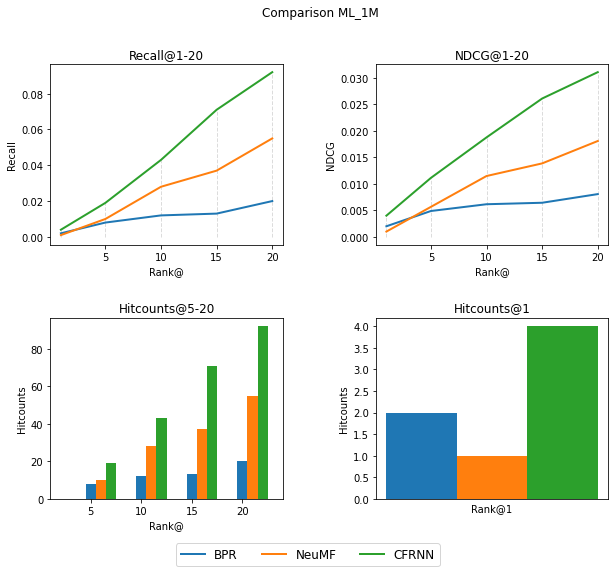

In [50]:
from visualize_results import plot_metrics
plot_metrics([bpr_metrics, neumf_metrics, cfrnn_metrics], 'Comparison ML_1M', ['BPR', 'NeuMF', 'CFRNN'])